In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

### Merging Datasets

In [128]:
path_snp = "Data/SPX_Weekly_06-14.csv"
path_10k = "Data/weekly_10k.csv"
path_10q = "Data/weekly_10q.csv"
path_8k = "Data/weekly_8k.csv"
path_news = "Data/weekly_smoothed_news.csv"

In [129]:
# Load weekly datasets
news = pd.read_csv(path_news, parse_dates=['Date']).rename(columns={'Date':'Week'})
tenk = pd.read_csv(path_10k, parse_dates=['Week'])
tenq = pd.read_csv(path_10q, parse_dates=['Week'])
eightk = pd.read_csv(path_8k, parse_dates=['Week'])
sp500 = pd.read_csv(path_snp, parse_dates=['Date']).rename(columns={'Date':'Week'})

In [130]:
# Extract just the date
for df in [news, tenk, tenq, eightk]:
    df['Week'] = df['Week'].dt.date

In [131]:
dfs = [news, tenk, tenq, eightk, sp500]

for df in dfs:
    # ensure Week is a datetime64[ns]
    df['Week'] = pd.to_datetime(df['Week'])

In [132]:
# Merge on Week
df = news.merge(tenk, on='Week', how='inner') \
         .merge(tenq, on='Week', how='inner') \
         .merge(eightk, on='Week', how='inner') \
         .merge(sp500, on='Week', how='inner')

In [133]:
df = df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])

In [134]:
df.head()

,Week,mean_news_sentiment,std_news_sentiment,num_positive,num_negative,num_neutral,num_articles,low_coverage_week,smoothed_sentiment,sent_10k_mean,...,sent_8k_mean,count_8k,Open,High,Low,Close,Adj Close,Volume,Year,log_return
0,2007-01-14,0.049556,0.407824,4,1,6,11,False,0.049556,-0.605603,...,-0.429737,231,1423.819946,1431.229980,1422.579956,1430.729980,1430.729980,2686480000,2007,0.014801
1,2007-02-04,0.065830,0.508994,5,2,10,17,False,0.065830,-0.508390,...,-0.574727,437,1445.939941,1449.329956,1444.489990,1448.390015,1448.390015,2569450000,2007,0.018262
2,2007-02-11,0.007639,0.354497,5,2,7,14,False,0.007639,-0.258283,...,-0.605214,384,1448.250000,1452.449951,1433.439941,1438.060059,1438.060059,2951810000,2007,-0.007158
3,2007-02-18,0.111990,0.445174,5,1,4,10,False,0.111990,-0.284438,...,-0.600544,346,1456.770020,1456.770020,1451.569946,1455.540039,1455.540039,2399450000,2007,0.012082
4,2007-02-25,0.083046,0.400443,2,0,2,4,True,0.097518,-0.417467,...,-0.547606,301,1456.219971,1456.219971,1448.359985,1451.189941,1451.189941,2579950000,2007,-0.002993


In [135]:
df.rename(columns={'smoothed_sentiment': 'smoothed_news_sentiment',
                  'num_articles': 'num_news_articles',
                  'mda_sent': '10q_mda_sent',
                  'risk_sent': '10q_risk_sent',
                  'mda_smoothed': '10q_mda_smoothed',
                  'risk_smoothed': '10q_risk_smoothed'}, inplace=True)

In [136]:
df.to_csv('Data/merged_dataset.csv', index=False)

# Modelling

### Using all the features

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# load merged dataset
df = pd.read_csv("Data/merged_dataset.csv", parse_dates=["Week"])
df = df.sort_values("Week").reset_index(drop=True)

In [3]:
# Compute weekly return and target
df["Return"] = df["Close"].pct_change()
df["Target"] = np.where(df["Return"] > 0.01, 1,
                np.where(df["Return"] < -0.01, -1, 0))
df = df.dropna(subset=["Return"])

In [4]:
df.columns

Index(['Week', 'mean_news_sentiment', 'std_news_sentiment', 'num_positive',
       'num_negative', 'num_neutral', 'num_news_articles', 'low_coverage_week',
       'smoothed_news_sentiment', 'sent_10k_mean', 'count_10k', '10q_mda_sent',
       '10q_risk_sent', 'count_10q', '10q_mda_smoothed', '10q_risk_smoothed',
       'opt_vs_caut', 'sent_8k_mean', 'count_8k', 'Open', 'High', 'Low',
       'Close', 'Adj Close', 'Volume', 'Year', 'log_return', 'Return',
       'Target'],
      dtype='object')

In [5]:
# Identify feature columns
exclude = {"Week", "Close", "Return", "Target", 'Year', 'Adj Close', 'mean_news_sentiment', 'std_news_sentiment', 'count_10k', '10q_mda_sent',
       '10q_risk_sent', 'count_10q', 'log_return'}
feature_cols = [c for c in df.columns if c not in exclude]

In [6]:
feature_cols

['num_positive',
 'num_negative',
 'num_neutral',
 'num_news_articles',
 'low_coverage_week',
 'smoothed_news_sentiment',
 'sent_10k_mean',
 '10q_mda_smoothed',
 '10q_risk_smoothed',
 'opt_vs_caut',
 'sent_8k_mean',
 'count_8k',
 'Open',
 'High',
 'Low',
 'Volume']

In [16]:
# Create lagged features
for lag in [1, 2]:
    df[[f"{col}_lag{lag}" for col in feature_cols]] = df[feature_cols].shift(lag)

In [17]:
df_model = df.dropna().reset_index(drop=True)

In [18]:
# Train/test split: 80/20
split = int(len(df_model) * 0.8)
train, test = df_model.iloc[:split], df_model.iloc[split:]
X_train, y_train = train[feature_cols + [f"{c}_lag1" for c in feature_cols] + [f"{c}_lag2" for c in feature_cols]], train["Target"]
X_test, y_test   = test[feature_cols + [f"{c}_lag1" for c in feature_cols] + [f"{c}_lag2" for c in feature_cols]], test["Target"]

In [19]:
# Fit RF
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [20]:
# Evaluate
acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

In [21]:
# Classification report to DataFrame and display
report_df = pd.DataFrame(report).transpose()
print("=== Classification Report ===")
print(report_df)

# Create a summary metrics DataFrame and display
summary_df = pd.DataFrame([{"Accuracy": acc, "Matthews CC": mcc}])
print("\n=== Summary Metrics ===")
print(summary_df)

=== Classification Report ===
              precision    recall  f1-score    support
-1             0.347826  0.727273  0.470588  11.000000
0              0.647059  0.550000  0.594595  20.000000
1              0.500000  0.200000  0.285714  15.000000
accuracy       0.478261  0.478261  0.478261   0.478261
macro avg      0.498295  0.492424  0.450299  46.000000
weighted avg   0.527549  0.478261  0.464219  46.000000

=== Summary Metrics ===
   Accuracy  Matthews CC
0  0.478261     0.250211


In [24]:
# Use the classifier's learned class order if available
labels = rf.classes_ if hasattr(rf, "classes_") else np.unique(y_test)

In [25]:
# 1) Raw confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=pd.Index(labels, name="True"), columns=pd.Index(labels, name="Predicted"))
print("Confusion matrix (counts):")
print(cm_df)

Confusion matrix (counts):
Predicted  -1   0   1
True                 
-1          8   1   2
 0          8  11   1
 1          7   5   3


In [26]:
# 2) Normalized by true class (rows sum to 1)
cm_norm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
cm_norm_df = pd.DataFrame(cm_norm, index=pd.Index(labels, name="True"), columns=pd.Index(labels, name="Predicted"))
print("\nConfusion matrix (row-normalized):")
print(cm_norm_df.round(3))


Confusion matrix (row-normalized):
Predicted     -1      0      1
True                          
-1         0.727  0.091  0.182
 0         0.400  0.550  0.050
 1         0.467  0.333  0.200


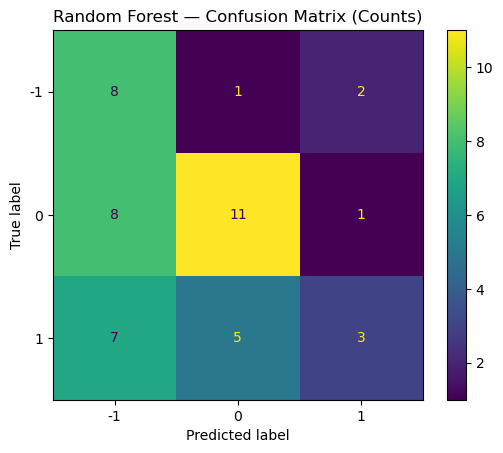

In [29]:
# 3) Plot (counts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format='d')
plt.title("Random Forest — Confusion Matrix (Counts)")
plt.show()

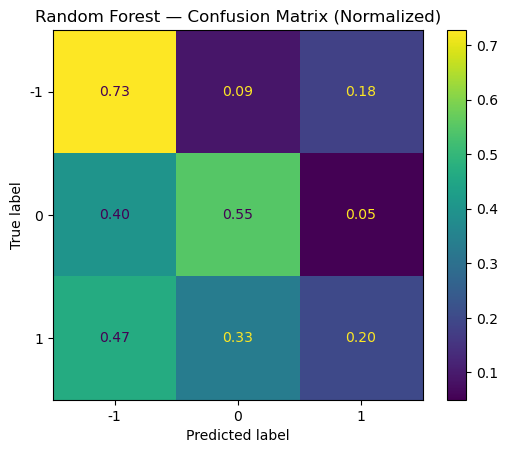

In [30]:
# Optional: plot normalized
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp_norm.plot(values_format='.2f')
plt.title("Random Forest — Confusion Matrix (Normalized)")
plt.show()

### Using core-features

In [113]:
# load merged dataset
df = pd.read_csv("Data/merged_dataset.csv", parse_dates=["Week"])
df = df.sort_values("Week").reset_index(drop=True)

In [114]:
# Compute weekly return and target
df["Return"] = df["Close"].pct_change()
df["Target"] = np.where(df["Return"] > 0.01, 1,
                np.where(df["Return"] < -0.01, -1, 0))
df = df.dropna(subset=["Return"])

In [117]:
# Define core features to keep
core_features = [
    "smoothed_news_sentiment", "std_news_sentiment", "num_news_articles",
    "sent_10k_mean", "count_10k",
    "10q_mda_smoothed", "10q_risk_smoothed", "opt_vs_caut",
    "sent_8k_mean", "count_8k"
]

In [118]:
# Create 1- and 2-week lags for each core feature
for lag in [1, 2]:
    for feat in core_features:
        df[f"{feat}_lag{lag}"] = df[feat].shift(lag)

In [119]:
# Drop rows with NaNs from lagging
df_model = df.dropna(subset=[f"{feat}_lag2" for feat in core_features]).reset_index(drop=True)

In [120]:
# Train/test split (80/20)
split_idx = int(len(df_model) * 0.8)
train = df_model.iloc[:split_idx]
test  = df_model.iloc[split_idx:]

In [123]:
# Prepare X/y
lagged_feats = [f"{feat}_lag{lag}" for feat in core_features for lag in [1,2]]
X_train = train[core_features + lagged_feats]
y_train = train["Target"]
X_test  = test[core_features + lagged_feats]
y_test  = test["Target"]

In [124]:
# Fit baseline Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [125]:
# Evaluate
acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

In [126]:
# Classification report to DataFrame and display
report_df = pd.DataFrame(report).transpose()
print("=== Classification Report ===")
print(report_df)

# Create a summary metrics DataFrame and display
summary_df = pd.DataFrame([{"Accuracy": acc, "Matthews CC": mcc}])
print("\n=== Summary Metrics ===")
print(summary_df)

=== Classification Report ===
              precision    recall  f1-score    support
-1             0.666667  0.181818  0.285714  11.000000
0              0.466667  0.350000  0.400000  20.000000
1              0.250000  0.466667  0.325581  15.000000
accuracy       0.347826  0.347826  0.347826   0.347826
macro avg      0.461111  0.332828  0.337099  46.000000
weighted avg   0.443841  0.347826  0.348404  46.000000

=== Summary Metrics ===
   Accuracy  Matthews CC
0  0.347826    -0.013861


# Debugging

In [12]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [17]:
feature_cols

['num_positive',
 'num_negative',
 'num_neutral',
 'num_news_articles',
 'low_coverage_week',
 'smoothed_news_sentiment',
 'sent_10k_mean',
 '10q_mda_smoothed',
 '10q_risk_smoothed',
 'opt_vs_caut',
 'sent_8k_mean',
 'count_8k',
 'Open',
 'High',
 'Low',
 'Volume']

In [21]:
# Prepare X and y
X = df[feature_cols + [f"{c}_lag1" for c in feature_cols] + [f"{c}_lag2" for c in feature_cols]]
y = df['Target']

In [26]:
final_features = feature_cols + [f"{c}_lag1" for c in feature_cols] + [f"{c}_lag2" for c in feature_cols]

In [22]:
# 1. TimeSeriesSplit class balance diagnostics
tscv = TimeSeriesSplit(n_splits=5)
print("Class balance per fold:\n")
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    print(f"Fold {i+1}:")
    print("  Train:", y_train.value_counts(normalize=True).to_dict())
    print("  Test: ", y_test.value_counts(normalize=True).to_dict())
    print()

Class balance per fold:

Fold 1:
  Train: {1: 0.38636363636363635, -1: 0.3181818181818182, 0: 0.29545454545454547}
  Test:  {-1: 0.4358974358974359, 1: 0.41025641025641024, 0: 0.15384615384615385}

Fold 2:
  Train: {1: 0.39759036144578314, -1: 0.37349397590361444, 0: 0.2289156626506024}
  Test:  {1: 0.41025641025641024, 0: 0.358974358974359, -1: 0.23076923076923078}

Fold 3:
  Train: {1: 0.4016393442622951, -1: 0.32786885245901637, 0: 0.27049180327868855}
  Test:  {1: 0.4358974358974359, -1: 0.3076923076923077, 0: 0.2564102564102564}

Fold 4:
  Train: {1: 0.40993788819875776, -1: 0.32298136645962733, 0: 0.2670807453416149}
  Test:  {0: 0.38461538461538464, 1: 0.38461538461538464, -1: 0.23076923076923078}

Fold 5:
  Train: {1: 0.405, -1: 0.305, 0: 0.29}
  Test:  {0: 0.4358974358974359, 1: 0.3333333333333333, -1: 0.23076923076923078}



##### Class balance is reasonably stable
Across all five folds, “up” (1) weeks make up roughly 39–41 % of the train splits and 33–44 % of the test splits; “down” (–1) weeks hover around 31–32 % in-train and 23–44 % out-of-sample; “flat” weeks fill the remainder. In other words, no fold is so skewed that your model sees almost no examples of one class—but the splits do drift by ±10 % in the test set. That variation can itself add noise to your performance read-out.

In [23]:
# 2. Feature–target Pearson correlations
corrs = X.corrwith(y).abs().sort_values(ascending=False)
corr_df = corrs.reset_index()
corr_df.columns = ['feature', 'abs_corr_with_target']
display(corr_df.head(10))

,feature,abs_corr_with_target
0,sent_8k_mean_lag2,0.136484
1,sent_10k_mean_lag2,0.115505
2,Volume,0.094279
3,num_neutral,0.092869
4,count_8k,0.076046
5,Low,0.076018
6,count_8k_lag2,0.071293
7,num_negative,0.070766
8,sent_8k_mean_lag1,0.069813
9,smoothed_news_sentiment_lag2,0.069806


##### Sentiment–return correlations are near zero
Even the best lagged sentiment feature ( sent_8k_mean_lag2, |ρ|≈0.14 ) explains only 2 % of weekly variance. The bulk of your sentiment and filing aggregates correlate with returns at |ρ|<0.08. That implies there’s no strong linear signal for the model to pick up.

In [27]:
# 3. Quick feature importance from a RandomForest
rf = RandomForestClassifier(random_state=0)
rf.fit(X, y)
fi = pd.Series(rf.feature_importances_, index=final_features).sort_values(ascending=False)
fi_df = fi.reset_index()
fi_df.columns = ['feature', 'importance']
display(fi_df.head(10))

,feature,importance
0,count_8k_lag1,0.034139
1,smoothed_news_sentiment,0.033302
2,Volume_lag2,0.031152
3,Low,0.030032
4,opt_vs_caut,0.029118
5,opt_vs_caut_lag1,0.028727
6,sent_8k_mean,0.028501
7,sent_10k_mean_lag2,0.028307
8,Volume,0.028121
9,count_8k_lag2,0.027591


##### The forest leans on price-based variables
Your top-10 importances are dominated by lagged count_8k, volume (and its lag), the “opt_vs_caut” ratio (and its lag), plus a handful of sentiment stats. In effect, the model is relying more on sheer article counts and trading volume than on semantic content (for example, sent_8k_mean appears lower than count_8k_lag1).

# Ablation

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [50]:
# load merged dataset
df = pd.read_csv("Data/merged_dataset.csv", parse_dates=["Week"])
df = df.sort_values("Week").reset_index(drop=True)

In [51]:
# Compute weekly return and target
df["Return"] = df["Close"].pct_change()
df["Target"] = np.where(df["Return"] > 0.01, 1,
                np.where(df["Return"] < -0.01, -1, 0))
df = df.dropna(subset=["Return"]).reset_index(drop=True)

In [52]:
# Define excluded columns and base features
exclude = {
    "Week", "Close", "Return", "Target", "Year", "Adj Close",
    "mean_news_sentiment", "std_news_sentiment",
    "count_10k", "10q_mda_sent", "10q_risk_sent", "count_10q", "log_return"
}

In [53]:
base_features = [col for col in df.columns if col not in exclude]
# Generate lag feature names
def make_lags(cols):
    return [f"{c}_lag1" for c in cols] + [f"{c}_lag2" for c in cols]

In [54]:
# Create lag features in dataframe
for col in base_features:
    df[f"{col}_lag1"] = df[col].shift(1)
    df[f"{col}_lag2"] = df[col].shift(2)
df = df.dropna().reset_index(drop=True)  # drop rows missing lags

In [55]:
# Define feature groups
price_feats = [c for c in base_features if c in ["Open", "High", "Low", "Volume"]]
sentiment_feats = [c for c in base_features if c not in price_feats]
feature_groups = {
    "Price/Volume": price_feats + make_lags(price_feats),
    "Sentiment/Filings": sentiment_feats + make_lags(sentiment_feats),
    "All Features": base_features + make_lags(base_features)
}

In [56]:
X = df  # we'll subset by columns later
y = df["Target"]

In [57]:
# TimeSeriesSplit setup
tscv = TimeSeriesSplit(n_splits=5)
results = []

In [58]:
# Ablation loops
for name, feats in feature_groups.items():
    feats = [c for c in feats if c in df.columns]  # ensure correct
    acc_scores, f1_scores = [], []
    for train_idx, test_idx in tscv.split(df):
        X_train, X_test = df.iloc[train_idx][feats], df.iloc[test_idx][feats]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, preds))
        f1_scores.append(f1_score(y_test, preds, average="macro"))
    results.append({
        "Feature Group": name,
        "Mean Accuracy": np.mean(acc_scores),
        "Std Accuracy": np.std(acc_scores),
        "Mean Macro-F1": np.mean(f1_scores),
        "Std Macro-F1": np.std(f1_scores)
    })

In [59]:
# Display results
results_df = pd.DataFrame(results)

In [60]:
results_df

,Feature Group,Mean Accuracy,Std Accuracy,Mean Macro-F1,Std Macro-F1
0,Price/Volume,0.416216,0.050128,0.342049,0.078114
1,Sentiment/Filings,0.372973,0.109984,0.329240,0.108073
2,All Features,0.340541,0.055652,0.287863,0.047858
